# FFT (Fast Fourier Transform)

The following pieces of code will define the FFT, which uses many different algorithms to compute the DFT of a list (or a matrix, which shall be discussed later) of data, defined as:

$\begin{align}X_k = \sum^{N-1}_{n=0}x_n ⋅ e^{-iτkn/N}, \;N ≜ length(x)\end{align}$

It may also be written as: 
$\begin{align}X_k = \sum^{N-1}_{n=0}x_n ⋅ ω^{kn}, \; N ≜ length(x),\;ω ≜ e^{-iτ/N}\end{align}$

depending on the size of the input list, as follows:

If $N$ is a power of 2, use a radix 2 FFT, else if $N$ is a prime number, use a rader FFT, else use a bluestein FFT.

These algorithms have a big $O$ notation of $O$($ N \cdot log(N) $), whereas manually computing the DFT has a big $O$ notation of $O$($N^2$). (I.e. as $N$ is scaled by some $k$, the time complexity of FFT algortithms increase by $k \cdot log(k)$, whereas the time complexity of a DFT increases by $k^2$).

This makes using these algorithms much more obvious than manual computation of the DFT, hence why they are so useful to us.


The following cell defines some starting code

In [13]:
using Primes

τ = 2π

# Displays a vector after formatting it (makes logs easier to read)
function format_display(x::Union{Vector{T}, Matrix{T}})::Nothing where T <: Real
    display(map(elem -> round(elem, digits=2), x))
end

# Displays a matrix after formatting it (makes logs easier to read)
function format_display(x::Union{Vector{T}, Matrix{T}})::Nothing where T <: Number
    display(map(elem -> round(real(elem), digits=2) + round(imag(x), digits=2)))
end

format_display (generic function with 2 methods)

## Radix 2 FFT 

The following code cell defines a radix 2 FFT

When N is a power of 2, one can rearrange the list by reversing the indices digits (in base 2). One can then recursively compute the FFT butterfly algorithm to reconstruct the desired FFT.

This can be simplified to: 

$\begin{align}FFT(x) = FFT(x_e) + (FFT(x_o) \cdot U^{(N/2)-1}_{n=0}ω^n) \; ⌢ \; FFT(x_e) - (FFT(x_o) \cdot U^{(N/2)-1}_{n=0}ω^n)\end{align}$

where $U_{r=a}^bf(r) = [f(a), f(a+1), ..., f(b-1), f(b)]$ and $⌢$ is concatenation.

It is thus clear to see that a radix 2 FFT is recursive, and this allows for a much faster computation than manually computing a DFT.

To ensure a StackOverflow error doesn't occur, we need a base case where the recursion should stop, which would be when $N = 1$, because then there will only be one element, and thus $n = 0$, and so the complex exponential component is just 1. This means that $FFT(x) = x$ when $N = 1$.

For reasons to be made clear later (see radix 2 IFFT), $ω$ shall be parameterised (to allow different values to be supplied). (By default, it will have a value of nothing, then will be initialised in the function).

In [14]:
function radix2FFT(x::Vector{T}, ω::Union{Complex{A}, Nothing} = nothing)::Vector{ComplexF64} where {T <: Number, A <: Number}
    N = length(x)
    
    if N == 1
        return x # One-point time domain spectrum is the same in frequency domain
    end

    if !ispow2(N)
        throw(ArgumentError("Input list must have a length of a power of 2"))
    end

    # ω ≜ exp(-im*τ/N) (if not already supplied, see IFFT for when different ω used) 
    if ω === nothing
        ω = exp(-im*τ/N)
    end    

    Xₑ = radix2FFT(x[1:2:end], ω^2) # Get the even indices of x (0-indexed) and recursively FFT (Julia is 1-indexed)
    Xₒ = radix2FFT(x[2:2:end], ω^2) # Get the odd indices of x (0-indexed) and recursively FFT (Julia is 1-indexed)

    res = zeros(ComplexF64, N)
    
    for i ∈ 1:N÷2
        res[i] = Xₑ[i] + Xₒ[i] * ω^(i-1) 
        res[i+N÷2] = Xₑ[i] - Xₒ[i] * ω^(i-1)
    end

    return res
end

radix2FFT (generic function with 2 methods)

## Radix 2 IFFT
The following code cell defines a radix 2 IFFT

The Inverse Discrete Fourier Transform is defined to be:

$\begin{align}x_n = \sum_{k=0}^{N-1}X_k ⋅ ω^{-kn/N}\end{align}$

Notice how this definition is very similar to that of the FFT, just that the exponent is the negative of the exponent in the FFT. This can be leveraged as follows:

$\begin{align}IFFT(X) = FFT(X,\; ω = e^{iτ/N})\end{align}$

hence why we parameterised $ω$ when writing the code to do the FFT.

We can also use this fact when making a rader_IFFT and a bluestein_IFFT (later on).

In [15]:
function radix2IFFT(x::Vector{T}, ω::Union{Complex{U}, Nothing} = nothing)::Vector{ComplexF64} where {T <: Number, U <: Number}
    N = length(x)

    if N == 1
        return x # One-point time domain spectrum is the same in frequency domain
    end

    if !ispow2(N)
        throw(ArgumentError("Input list must have a length of a power of 2"))
    end

    # Initialise root of unity to be used
    if ω === nothing
        ω = exp(τ*im/N)
    end

    return radix2FFT(x, 1/ω) ./ N # Supply 1/ω because exp(-iτ/N) = 1/exp(iτ/N)
end

radix2IFFT (generic function with 2 methods)

## Rader FFT

The Rader FFT can be used on prime length inputs because if $N$ (the length of the inputs is prime), the following is true:

$\begin{align}(\frac{\mathbb{Z}}{N\mathbb{Z}})^{\ast} = C_{N-1}\end{align}$ where $C_{N-1}$ is the cyclic group of order $N-1$.

Since the DFT at k = 0 is just the sum of the input data, we can rewrite the DFT as the following:

$\begin{align}X_k = x_0 + \sum_{n=1}^{N-1}x_n ⋅ e^{-iτkn/N}\end{align}$ where $x_0 ≜ \sum x$
and the indices of n are present in the cyclic group $C_{N-1}$

By definition of a cyclic group, the cyclic group $C_{N-1}$ has a generator, and let this be $g$. ($g$ is a primitive root of $N$).

(A primitive root, $g$, of a prime number, $p$, is an integer, $g$, such that every integer coprime to p, $a$ (i.e. gcd(p, a) = 1) ≡ $g^z$ (mod p) for some integer $z$).

We can rewrite $n$ as: $g^{q_n}\\$
and $k$ as: $(g^{-1})^{p_k}$ = $g^{-p_k}$

$k ↦ p_k$ and $n ↦ q_n$ are bijections, since the order of $C_{N-1}$ is $N-1$ and $n,k\in\{0,1,2,...,N-2\}$

Thus we can rewrite the DFT as:

$\begin{align}X_{g^{-p}} = x_0 + \sum^{N-2}_{q=0}x_{g^q} ⋅ ω^{g^{-(p-q)}}\end{align}$

This is now the cyclic convolution of $u(z) = ω^{g^{-z}}$ and $v(z) = x_{g^z}$

and using the convolution theorem, which states that:

$\begin{align}\mathcal{F}\{x \ast y\} = \mathcal{F}\{x\} ⋅ \mathcal{F}\{y\}\end{align}$

To calculate the cyclic convolution of two lists, A and B, both of length M, pad them with zeros until they have a length L, where:

$\begin{align}L ≜ 2^{⌈log_2(M)⌉}\end{align}$
$\begin{align}\mathcal{A} = A\;(padded\;with\;L - M\;0s)\end{align}$
$\begin{align}\mathcal{B} = B\;(padded\;with\;L - M\;0s)\end{align}$


then we can convolve $\mathcal{A}$ and $\mathcal{B}$ using a radix 2 FFT and radix 2 IFFT.

To then recover $A \ast B$, we can use:

$\begin{align}(A \ast B)_k = (\mathcal{A} \ast \mathcal{B})_k + (\mathcal{A} \ast \mathcal{B})_{k+m}\end{align}$



In [16]:
# Finds the smallest primitive root of m (m must be prime)
function primroot(m::Int64)::Int64
    if !isprime(m)
        error("Argument 'm' must be a prime number")
    end

    if m == 2
        return 1 # 1 is the smallest primitive root of 2
    end

    P = keys(factor(m-1)) # Get prime factors of m-1
    for r = 2:(m-1)
        not_found = true
        for p in P
            if powermod(r, div(m-1, p), m) == 1
                not_found = false
            end
        end

        if not_found
            return r
        end
    end

    return 0
end

# Successive powers of g up to m - 1, all mod m
function sequence(g::Int64, m::Int64)::Vector{Int64}
    return [(big(g)^i)%m for i ∈ 0:m-2]
end

# Use to generate the entire group (𝐙/p𝐙)* and successive powers (p is prime)
function generator(p::Int64)::Tuple{Int64, Vector{Int64}}
    if !isprime(p)
        throw(ArgumentError("p must be prime"))
    end

    return primroot(p), sequence(primroot(p), p)
end

# FFT convolution of u and v, where u and v are of the same length (uses padding)
function convolve(u::Vector{T}, v::Vector{U})::Vector{Number} where {T <: Number, U <: Number}
    if length(u) != length(v)
        throw(ArgumentError("Input vectors must be of the same length"))
    end

    N = length(u)
    L = 2^ceil(log2(2N+1))
    ωₗ = exp(τ*im/L)

    fft_uₗ = radix2FFT(vcat(u, [0 for _ ∈ 1:L-N]), ωₗ)
    fft_vₗ = radix2FFT(vcat(v, [0 for _ ∈ 1:L-N]), ωₗ)

    # Convolution theorem: 𝓕{u(x) ∗ v(x)} = 𝓕{u(x)} . 𝓕{v(x)}
    uₗvₗ = radix2IFFT(fft_uₗ .* fft_vₗ)

    return [uₗvₗ[i] + uₗvₗ[i + N] for i in 1:N]
end

function rader_FFT(x::Vector{T}, ω::Union{Complex{A}, Nothing} = nothing)::Vector{ComplexF64} where {T <: Number, A <: Number}
    N = length(x)

    if !isprime(N)
        throw(ArgumentError("List must have a prime length"))
    end

    # ω ≜ exp(-im*τ/N) (if not already supplied, see IFFT for when different ω used) 
    if ω === nothing
        ω = exp(-τ*im/N)
    end

    g, g_seq = generator(N) # Generate g and its successive powers
    g⁻¹ = (g^(N-2))%N # Mulitplicative inverse of g (mod N)
    g⁻¹_seq = sequence(g⁻¹, N) # Successive powers of g⁻¹

    # u(z) = ω^g⁻ᶻ
    u = [ω^gₙ for gₙ ∈ g⁻¹_seq]

    # v(z) = x[gᶻ]
    v = [x[gᶻ+1] for gᶻ ∈ g_seq]

    uv = convolve(u, v)

    fft = zeros(ComplexF64, N)
    fft[1] = sum(x) # FFT[0] = ∑ᵢ xᵢ (Julia is 1-indexed)

    # FFT[g⁻ʲ] = a₀ + (u * v)ⱼ (Julia is 1-indexed)
    for i in 1:N-1
        fft[g⁻¹_seq[i] + 1] = x[1] + uv[i]
    end

    return fft
end

rader_FFT (generic function with 2 methods)

## Rader IFFT
The following code cell defines a rader IFFT.

From the reasoning presented for the radix 2 IFFT, we know that:

$IFFT(X) = FFT(X, \; ω = e^{iτ/N})$

and here we shall leverage this fact to make a rader IFFT

In [17]:
function rader_IFFT(x::Vector{T}, ω::Union{Complex{U}, Nothing} = nothing)::Vector{ComplexF64} where {T <: Number, U <: Number}
    N = length(x)

    if !isprime(N)
        throw(ArgumentError("Input list must have a prime length"))
    end

    # Initialise ω to principal Nth root of unity if not supplied
    if ω === nothing
        ω = exp(τ*im/N)
    end

    return rader_FFT(x, 1/ω) ./ N # Supply 1/ω because exp(-iτ/N) = 1/exp(iτ/N)
end

rader_IFFT (generic function with 2 methods)

## Bluestein FFT
The following code cell defines a bluestein FFT, which is used when $N$ is not a power of 2 or prime.

The Chirp Z Transform (CZT) is a generalisation of the DFT which samples on spiral arcs in the Z-plane (complex input plane, similar to k in the DFT).

The CZT can be defined as (for some given A, W and M):

$X_k = \sum_{n=0}^{N-1}x_nz_k^{-n}$, where $z_k = A ⋅ W^{-k},\;k=0,1,...,M-1$

Returning to the definition of the DFT:

$\begin{align}X_k = \sum^{N-1}_{n=0}x_n ⋅ ω^{kn}\end{align}$

We can replace kn using the following identity:

$\begin{align}kn ≡ \frac{k^2 + n^2 - (k - n)^2}{2}\end{align}$

as such:

$\begin{align}X_k = \sum^{N-1}_{n=0}x_n ⋅ ω^{\frac{k^2 + n^2 - (k - n)^2}{2}}\end{align}$

$\begin{align}X_k = \sum^{N-1}_{n=0}x_n ⋅ ω^{n^2/2} ⋅ ω^{k^2/2} ⋅ ω^{-(k-n)^2/2}\end{align}$

$\begin{align}X_k = ω^{k^2/2} ⋅ \sum^{N-1}_{n=0}(x_n ⋅ ω^{n^2/2}) ⋅ ω^{-(k-n)^2/2}\end{align}$

This is now just the convolution of the sequences:

$\begin{align}u(z) = x_z ⋅ ω^{n^2/2}\end{align}$

$\begin{align}v(z) = ω^{-n^2/2}\end{align}$

but one must consider the fact that the result of the convolution will need to be multiplied by $ω^{k^2/2}$ to get the desired DFT, and so one must multiply by that in the end. Thus we can rewrite the DFT as:

$\begin{align}X_k = ω^{k^2/2} ⋅ (\sum^{N-1}_{n=0}u(n) ⋅ v(k-n))\end{align}$

$\begin{align}X_k = ω^{k^2/2} ⋅ (u ∗ v)_k\end{align}$

Using the convolution theorem (stated previously):

$\begin{align}X_k = ω^{k^2/2} ⋅ (u ∗ v)_k\end{align}$

$\begin{align}X_k = ω^{k^2/2} ⋅ IFFT(FFT(u) ⋅ FFT(v))\end{align}$

In [18]:
function bluestein_FFT(x::Vector{T}, ω::Union{Complex{A}, Nothing} = nothing) where {T <: Number, A <: Number}
    N = length(x)

    if N == 1
        return x
    end

    # Initialise ω to exp(iτ/N) if not supplied
    # Supply different ω for IFFT
    if ω === nothing 
        ω = exp(τ*im/N)
    end

    # Make lists u(n) and v(n)
    u = [x[i+1] * ω^(-(i^2)/2) for i ∈ 0:N-1]
    v = [ω^((i^2)/2) for i ∈ 0:N-1]
    v_star = [ω^(-(i^2)/2) for i ∈ 0:N-1]

    L = 2^ceil(log2(2*N+1))
    ωₗ = exp(log(ω) * N/L) # exp(τ*im/L) # Calculate root of unity required

    uₗ = vcat(u, [0 for _ ∈ 1:L-N]) # Pad u(n)

    # Pad v(n) and shift
    aux = v[2:end]
    reverse!(aux)
    vₗ = vcat(v, [0 for i ∈ 1:L - 2*N + 1], aux)

    # FFT convolve
    fft_uₗ = radix2FFT(uₗ, ωₗ)
    fft_vₗ = radix2FFT(vₗ, ωₗ)

    uvₗ = fft_uₗ .* fft_vₗ

    iftₗ = radix2IFFT(uvₗ, ωₗ)

    ift = iftₗ[begin:N]

    # Multiply the IFT by v_star to get result
    return v_star .* ift
end

bluestein_FFT (generic function with 2 methods)

## Bluestein IFFT
The following code cell defines a bluestein IFFT.

From the reasoning presented for the radix 2 IFFT, we know that:

$\begin{align}IFFT(X) = FFT(X, \; ω = e^{iτ/N})\end{align}$

and here we shall leverage this fact to make a bluestein IFFT.

In [19]:
function bluestein_IFFT(x::Vector{T}, ω::Union{Complex{U}, Nothing} = nothing) where {T <: Number, U <: Number}
    N = length(x)

    if N == 1
        return x
    end

    if ω === nothing
        ω = exp(τ*im/N)
    end

    return bluestein_FFT(x, 1/ω) ./ N
end

bluestein_IFFT (generic function with 2 methods)

## General FFT and IFFT
Now that we have made special functions to compute the FFT depending on the length of then input, to make the code simpler to use, we can define a single fft and a single ifft function, which will automatically determine the correct type of FFT to use.

P.S: It turns out after some testing that even for prime length inputs the Bluestein FFT is much faster than the Rader FFT, we shall just use the Bluestein FFT even for prime length inputs.

In [27]:
function fft(x::Vector{T}, ω::Union{Complex{U}, Nothing} = nothing) where {T <: Number, U <: Number}
    N = length(x)

    # Initialise ω to exp(iτ/N) if not supplied
    # See IFFT for when different ω supplied
    if ω === nothing
        ω = exp(im*τ/N)
    end

    if ispow2(N)
        return radix2FFT(x, ω)
    else
        return bluestein_FFT(x, ω)
    end
end

function ifft(x::Vector{T}, ω::Union{Complex{U}, Nothing} = nothing) where {T <: Number, U <: Number}
    N = length(x)

    # Initialise ω to principal Nth root of unity if not supplied
    if ω === nothing
        ω = exp(τ*im/N)
    end

    return fft(x, 1/ω) ./ N
end

ifft (generic function with 2 methods)

# 2D FFT/IFFT
The first cell defines functions to convert a matrix into a vector of columns, a vector of rows and vice versa.

The FFT and IFFT can be applied to matrices as well as lists. To apply the FFT to a matrix, you apply the 1D FFT to each column, and then construct a matrix using the FFT of the columns. We then apply the FFT to the rows of the matrix before then returning that as the result.

To do the IFFT, one simply applies the IFFT to the columns, then to the rows of the resultant matrix, before then returning that as the result.

In [21]:
# Convert Matrix{T} into Vector{Vector{T}} (a vector of the columns of the input matrix)
function columns(x::Matrix{T})::Vector{Vector{T}} where T <: Any
    return [x[begin:end, i] for i ∈ 1:size(x)[2]]
end

# Convert Matrix{T} into Vector{Vector{T}} (a vector of the rows of the input matrix)
function rows(x::Matrix{T})::Vector{Vector{T}} where T <: Any
    return [x[i, begin:end] for i ∈ 1:size(x)[1]]
end

# Converts Vector{Vector{T}} into Matrix{T}. Columns specifies whether the input is a vector of columns (true) or a vector of rows (false)
function convert_to_matrix(x::Vector{Vector{T}}, columns::Bool = false)::Matrix{T} where T <: Any
    if columns
        res = zeros(T, length(x[1]), length(x))
        for i ∈ 1:length(x)
            res[begin:end, i] = x[i]
        end
        return res
    else
        res = zeros(T, length(x), length(x[1]))
        for i ∈ 1:length(x)
            res[i, begin:end] = x[i]
        end
        return res
    end
end

convert_to_matrix (generic function with 2 methods)

In [22]:
function fft2(x::Matrix{T}, ω::Union{Complex{A}, Nothing} = nothing)::Matrix{ComplexF64} where {T <: Number, A <: Number}
    fft_columns = [fft(i, ω) for i ∈ columns(x)]
    fft_rows = [fft(i, ω) for i ∈ rows(convert_to_matrix(fft_columns, true))]
    return convert_to_matrix(fft_rows)
end

function ifft2(x::Matrix{T}, ω::Union{Complex{A}, Nothing} = nothing)::Matrix{ComplexF64} where {T <: Number, A <: Number}
    ifft_columns = [ifft(i, ω) for i ∈ columns(x)]
    ifft_rows = [ifft(i, ω) for i ∈ rows(convert_to_matrix(ifft_columns, true))]
    return convert_to_matrix(ifft_rows)
end

ifft2 (generic function with 2 methods)

# Using the FFT

The FFT can be used for many applications, both due to the utility of being able to analyse measurements about waves, and being able to compute convolutions much faster than otherwise, due to the convolution theorem, which I shall restate:

$\begin{align}\mathcal{F}\{f(x) \ast g(x)\} = \mathcal{F}\{f(x)\} ⋅ \mathcal{F}\{g(x)\}\end{align}$

which is then very useful for computing convolutions, which themselves are used in many different fields of mathematics and computer science, e.g. Convolutional Neural Networks, image processing, etc.

For now, we shall make methods to convolve matrices and lists, and demonstrate a simple use of convolution: to blur an image.

## Convolution
The following code cell defines code for a 1D and a 2D convolution respectively (using the corresponding FFT and IFFT implementations).

Before doing an FFT convolution, one has to pad the input lists with zeros to length $M + N - 1$ where $M$ and $N$ are the lengths of the input lists, or for matrices, each input needs to be padded with zeros along each dimesion to a length of $M + N - 1$ where in this case, $M$ and $N$ are the sizes of the input matrices in the required dimension.

In [23]:
function conv(x::Vector{T}, y::Vector{U})::Vector{ComplexF64} where {T <: Number, U <: Number}
    # Pad to correct dimensions
    x = vcat(x, [0 for _ ∈ 1:length(y) - 1])
    y = vcat(y, [0 for _ ∈ 1:length(x) - 1])
    return ifft(fft(x) .* fft(y))
end

function conv2(x::Matrix{T}, y::Matrix{U})::Matrix{ComplexF64} where {T <: Number, U <: Number}
    # Pad to correct dimensions
    new_m = size(x)[1] + size(y)[1] - 1
    new_n = size(x)[2] + size(y)[2] - 1

    new_x = zeros(T, new_m, new_n)
    new_y = zeros(U, new_m, new_n)
    
    new_x[1:size(x)[1], 1:size(x)[2]] = x
    new_y[1:size(y)[1], 1:size(y)[2]] = y

    x = new_x
    y = new_y
    
    return ifft2(fft2(x) .* fft2(y))
end

conv2 (generic function with 1 method)

## Blurring an image
An image can be blurred by convolving it with a certain kernel (which is just a matrix), where the centre is focused more than the edges. We shall use the following kernel:

$\begin{align}k =
\begin{bmatrix}
0.05 & 0.1 & 0.05\\
0.1 & 0.5 & 0.1\\
0.05 & 0.1 & 0.05\\
\end{bmatrix}\end{align}
$

and we will use "image.jpeg".

An image can be thought of as 3 matrices, one for red, one for green and one for blue. We can simply convolve the kernel with each colour channel matrix, before then recombining the resultant matrices to form an image.

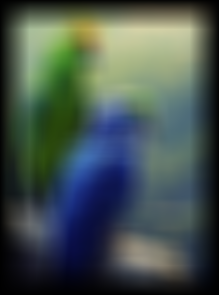

In [32]:
using Images, FileIO

img = load("image.jpeg")
kernel = convert_to_matrix([[1/900 for _ ∈ 1:30] for _ ∈ 1:30])

red_mat = map(x -> Float64(x), channelview(img)[1, begin:end, begin:end])
green_mat = map(x -> Float64(x), channelview(img)[2, begin:end, begin:end])
blue_mat = map(x -> Float64(x), channelview(img)[3, begin:end, begin:end])

new_red_mat = conv2(kernel, red_mat)
new_green_mat = conv2(kernel, green_mat)
new_blue_mat = conv2(kernel, blue_mat)

rgb_mat = zeros(RGB, size(new_red_mat)[1], size(new_red_mat)[2])

for i ∈ 1:size(new_red_mat)[1]
    for j ∈ 1:size(new_red_mat)[2]
        rgb_mat[i, j] = RGB(real(new_red_mat[i, j]), real(new_green_mat[i, j]), real(new_blue_mat[i, j]))
    end
end

rgb_mat